Following along: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

## Problem
We want to predict the survival of each passenger on the Titanic based on what limited information we have about each passenger.

## Data

In [21]:
import os
import csv
from pprint import pprint

In [2]:
os.listdir('/data/titanic')

['gender_submission.csv', 'test.csv', 'train.csv']

In [3]:
with open('/data/titanic/train.csv') as test_f:
    reader = csv.reader(test_f)
    print(reader.__next__())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


As demonstrated by reviewing the headers of `test.csv`, we have the following fields to work with:
- ID (PassengerId)
- Survived? (Survived)
- Socioeconomic Class (Pclass)
- Name (Name)
- Sex (Sex)
- Age (Age)
- Number of Siblings Onboard (SibSp)
- Number of Parents Onboard (Parch)
- Ticket Number (Ticket)
- Fare (Fare)
- Cabin Number (Cabin)
- Port of Embarkation (Embarked)

Reference: https://www.kaggle.com/c/titanic/data

## Data Cleaning

In [4]:
import sys
import pandas as pd
import matplotlib as mpl
import numpy as np
import scipy as sp
import IPython
import sklearn

import random
import time

import warnings
warnings.filterwarnings('ignore')


from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [5]:
raw_df = pd.read_csv('/data/titanic/train.csv')
vaOn 15 July 1918, Carpathia departed Liverpool in a convoy bound for Boston carrying 57 passengers (36 saloon class and 21 steerage) and 166 crew. At 9:15 a.m. on the morning of 17 July, while sailing in the Southwest Approaches she was torpedoed near the No. 3 hatch on the port side by the Imperial German Navy submarine U-55, followed by a second which penetrated the engine room, killing three firemen and two trimmers.[27] As Carpathia began to settle by the head and list to port, Captain William Prothero gave the order to abandon ship. All passengers and the surviving crew members boarded the lifeboats as the vessel sank.[27] There were 218 survivors.[27] U-55 surfaced and fired a third torpedo into the ship near the gunner's rooms, resulting in a big explosion that doomed the ship.[27] U-55 started approaching the lifeboats when the Azalea-class sloop HMS Snowdrop arrived on the scene and drove away the submarine with gunfire before picking up the survivors from Carpathia.

lidation_df = pd.read_csv('/data/titanic/test.csv')
working_df = raw_df.copy(deep=True)

cleaner = [working_df, validation_df]

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
raw_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
499,500,0,3,"Svensson, Mr. Olof",male,24.0,0,0,350035,7.7958,NaN,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S
696,697,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
707,708,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
640,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
529,530,0,2,"Hocking, Mr. Richard George",male,23.0,2,1,29104,11.5000,NaN,S
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S


In [8]:
print('Training columns with Null Values', working_df.isnull().sum())
print('Validation columns with Null Values', validation_df.isnull().sum())

Training columns with Null Values PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Validation columns with Null Values PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [9]:
for dataset in cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
drop_column = ['PassengerId', 'Cabin', 'Ticket']
working_df.drop(drop_column, axis=1, inplace=True)

In [10]:
print('Working columns with Null Values', working_df.isnull().sum())
print('Validation columns with Null Values', validation_df.isnull().sum())

Working columns with Null Values Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Validation columns with Null Values PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [11]:
for dataset in cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(", ", expand = True)[1].str.split(".", expand=True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

In [12]:
stat_min = 10
title_names = (working_df['Title'].value_counts() < stat_min)
title_names

Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Mlle             True
Col              True
Major            True
Mme              True
Lady             True
Don              True
Capt             True
the Countess     True
Sir              True
Ms               True
Jonkheer         True
Name: Title, dtype: bool

In [13]:
working_df['Title'] = working_df['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
working_df['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [14]:
print(working_df.info())
print(validation_df.info())
working_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-nu

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
414,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,7.9250,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
598,0,3,"Boulos, Mr. Hanna",male,28.0,0,0,7.2250,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
672,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,10.5000,S,1,1,Mr,"(7.91, 14.454]","(64.0, 80.0]"
158,0,3,"Smiljanic, Mr. Mile",male,28.0,0,0,8.6625,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
465,0,3,"Goncalves, Mr. Manuel Estanslas",male,38.0,0,0,7.0500,S,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
456,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,26.5500,S,1,1,Mr,"(14.454, 31.0]","(64.0, 80.0]"
54,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,61.9792,C,2,0,Mr,"(31.0, 512.329]","(64.0, 80.0]"
768,0,3,"Moran, Mr. Daniel J",male,28.0,1,0,24.1500,Q,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
116,0,3,"Connors, Mr. Patrick",male,70.5,0,0,7.7500,Q,1,1,Mr,"(-0.001, 7.91]","(64.0, 80.0]"
20,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,26.0000,S,1,1,Mr,"(14.454, 31.0]","(32.0, 48.0]"


## Encode

In [24]:
label = LabelEncoder()
for dataset in cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
target = ['Survived']

working_df_x_pretty = [
    'Sex',
    'Pclass',
    'Embarked',
    'Age',
    'Fare',
    'FamilySize',
    'IsAlone',
    'Title',
    'SibSp',
    'Parch'
]
working_df_x_calc = [
    'Sex_Code',
    'Pclass',
    'Embarked_Code',
    'Age',
    'Fare',
    'FamilySize',
    'IsAlone',
    'Title_Code',
    'SibSp',
    'Parch'
]
working_df_x_bin = [
    'Sex_Code',
    'Pclass',
    'Embarked_Code',
    'AgeBin_Code',
    'FareBin_Code',
    'FamilySize',
    'IsAlone',
    'Title_Code',
    'SibSp',
    'Parch'
]

working_xy = target + working_df_x_pretty
working_xy_bin = target + working_df_x_bin

working_dummy = pd.get_dummies(working_df[working_df_x_pretty])
working_x_dummy = working_dummy.columns.tolist()
working_xy_dummy = target + working_x_dummy

print('Working XY', working_xy, '\n')
print('Bin XY', working_xy_bin, '\n')
print('Dummy XY', working_xy_dummy, '\n')
working_dummy.head()

Working XY ['Survived', 'Sex', 'Pclass', 'Embarked', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Title', 'SibSp', 'Parch'] 

Bin XY ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'AgeBin_Code', 'FareBin_Code', 'FamilySize', 'IsAlone', 'Title_Code', 'SibSp', 'Parch'] 

Dummy XY ['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'SibSp', 'Parch', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,Age,Fare,FamilySize,IsAlone,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,22.0,7.2500,2,0,1,0,0,1,0,0,1,0,0,0,1,0
1,1,38.0,71.2833,2,0,1,0,1,0,1,0,0,0,0,0,0,1
2,3,26.0,7.9250,1,1,0,0,1,0,0,0,1,0,0,1,0,0
3,1,35.0,53.1000,2,0,1,0,1,0,0,0,1,0,0,0,0,1
4,3,35.0,8.0500,1,1,0,0,0,1,0,0,1,0,0,0,1,0


In [26]:
print(working_df.isnull().sum())
print(working_df.info())

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null category
AgeBin           891 non-null category
Sex

In [27]:
print(validation_df.isnull().sum())
print(validation_df.info())

PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            327
Embarked           0
FamilySize         0
IsAlone            0
Title              0
FareBin            0
AgeBin             0
Sex_Code           0
Embarked_Code      0
Title_Code         0
AgeBin_Code        0
FareBin_Code       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
I

In [29]:
raw_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Carter, Rev. Ernest Courtenay",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [36]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(
    working_df[working_df_x_calc],
    working_df[target],
    random_state = 0
)

train_x_bin, test_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(
    working_df[working_df_x_bin],
    working_df[target],
    random_state = 0
)

train_x_dummy, test_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(
    working_dummy[working_x_dummy],
    working_df[target],
    random_state = 0
)

print('Working Shape: {}'.format(working_df.shape))
print('Train Shape: {}'.format(train_x.shape))
print('Test Shape: {}'.format(test_x.shape))

train_x_bin.head()

Working Shape: (891, 19)
Train Shape: (668, 10)
Test Shape: (223, 10)


,Sex_Code,Pclass,Embarked_Code,AgeBin_Code,FareBin_Code,FamilySize,IsAlone,Title_Code,SibSp,Parch
105,1,3,2,1,0,1,1,3,0,0
68,0,3,2,1,1,7,0,2,4,2
253,1,3,2,1,2,2,0,3,1,0
320,1,3,2,1,0,1,1,3,0,0
706,0,2,2,2,1,1,1,4,0,0


In [42]:
for x in working_df_x_pretty:
    print(x)
    if working_df[x].dtype != 'float64':
        print('Survival Corr by:', x)
        print(working_df[[x, target[0]]].groupby(x, as_index=False).mean())

Sex
Survival Corr by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
Pclass
Survival Corr by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
Embarked
Survival Corr by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
Age
Fare
FamilySize
Survival Corr by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
IsAlone
Survival Corr by: IsAlone
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
Title
Survival Corr by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
SibSp
Survival Corr by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5 

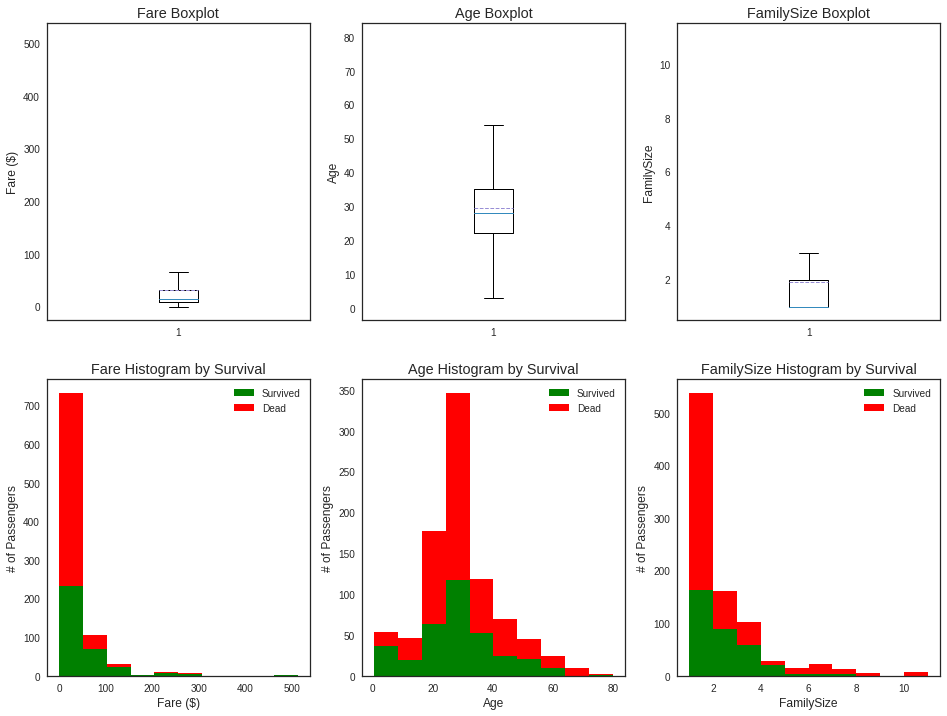

In [52]:
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(
    x = working_df['Fare'],
    showmeans = True,
    meanline = True,
    showfliers = True
)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(
    x = working_df['Age'],
    showmeans = True,
    meanline = True
)
plt.title('Age Boxplot')
plt.ylabel('Age')


plt.subplot(233)
plt.boxplot(
    x = working_df['FamilySize'],
    showmeans = True,
    meanline = True
)
plt.title('FamilySize Boxplot')
plt.ylabel('FamilySize')

plt.subplot(234)
plt.hist(
    x = [
        working_df[working_df['Survived'] == 1]['Fare'],
        working_df[working_df['Survived'] == 0]['Fare']
    ],
    stacked=True,
    color=['g','r'],
    label=['Survived', 'Dead']
)
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(
    x = [
        working_df[working_df['Survived'] == 1]['Age'],
        working_df[working_df['Survived'] == 0]['Age']
    ],
    stacked=True,
    color=['g','r'],
    label=['Survived', 'Dead']
)
plt.title('Age Histogram by Survival')
plt.xlabel('Age')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(
    x = [
        working_df[working_df['Survived'] == 1]['FamilySize'],
        working_df[working_df['Survived'] == 0]['FamilySize']
    ],
    stacked=True,
    color=['g','r'],
    label=['Survived', 'Dead']
)
plt.title('FamilySize Histogram by Survival')
plt.xlabel('FamilySize')
plt.ylabel('# of Passengers')
plt.legend()

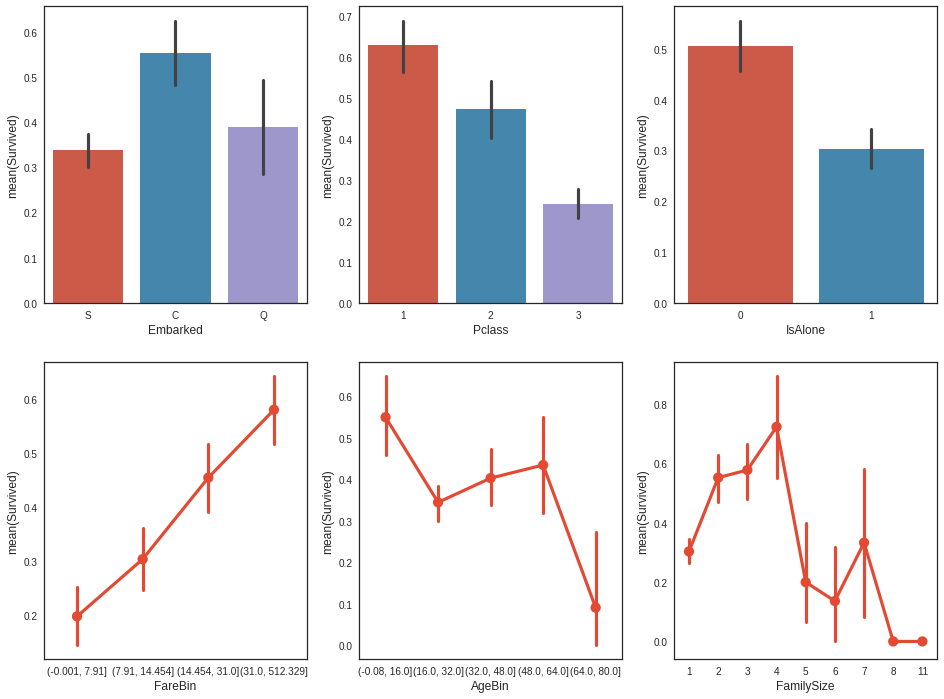

In [59]:
fig, saxis = plt.subplots(2, 3, figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=working_df, ax=saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=working_df, ax=saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', data=working_df, ax=saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived', data=working_df, ax=saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived', data=working_df, ax=saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=working_df, ax=saxis[1,2])

Text(0.5,1,'FamilySize v Fare')

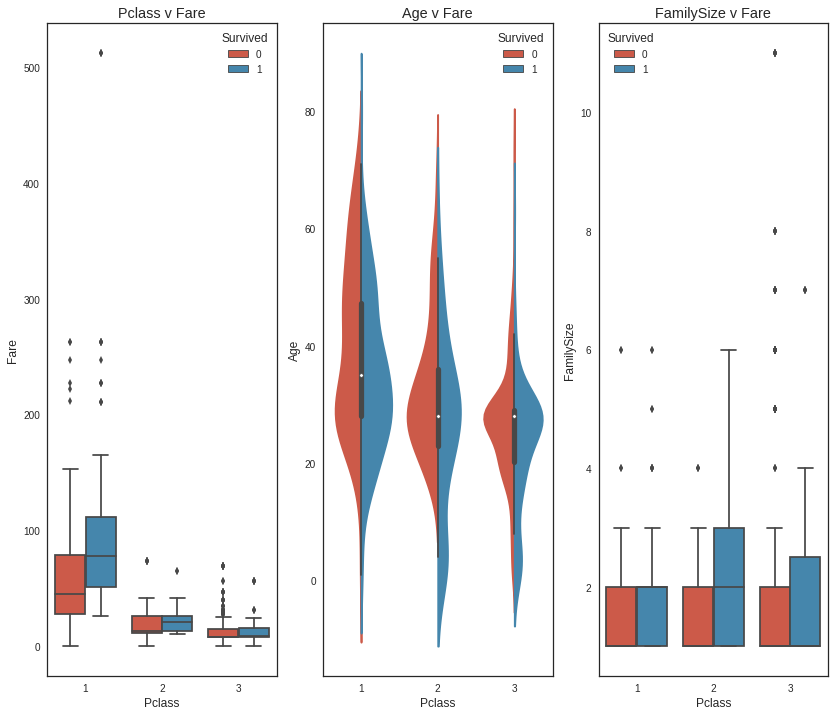

In [67]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(14, 12))

sns.boxplot(
    x='Pclass',
    y='Fare',
    hue='Survived',
    data=working_df,
    ax=axis1
)
axis1.set_title('Pclass v Fare')

sns.violinplot(
    x='Pclass',
    y='Age',
    hue='Survived',
    data=working_df,
    split=True,
    ax=axis2
)
axis2.set_title('Age v Fare')

sns.boxplot(
    x='Pclass',
    y='FamilySize',
    hue='Survived',
    data=working_df,
    ax=axis3
)
axis3.set_title('FamilySize v Fare')

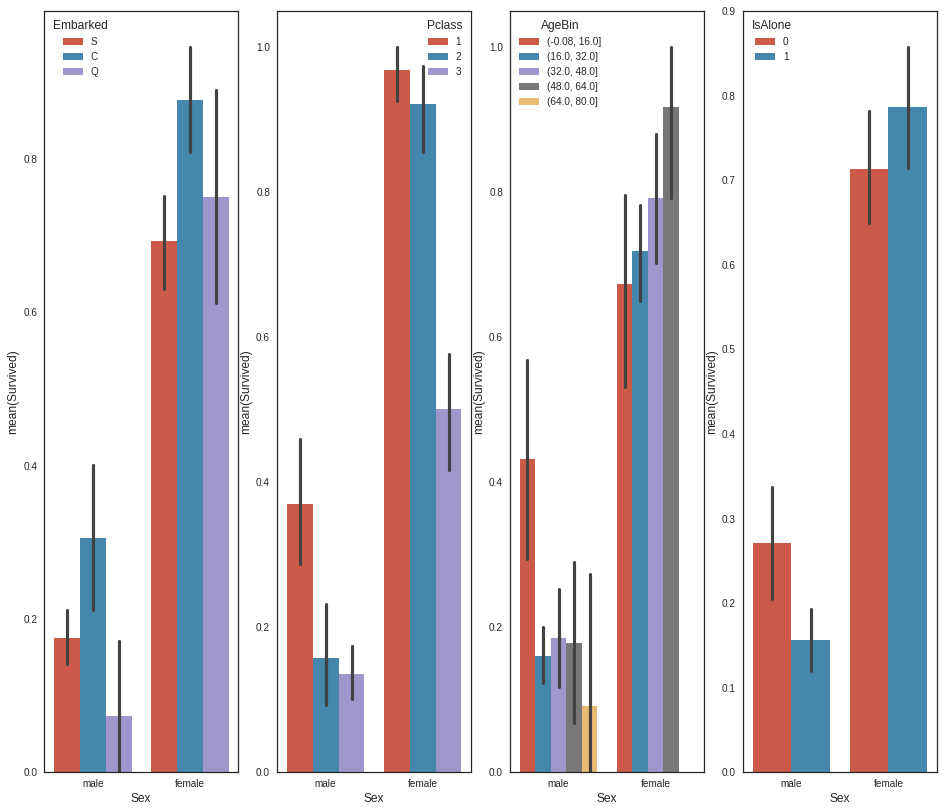

In [79]:
fig, (axis1, axis2, axis3, axis4) = plt.subplots(1, 4, figsize=(16,14))


sns.barplot(
    x = 'Sex',
    y = 'Survived',
    hue = 'Embarked',
    data=working_df,
    ax=axis1
)

sns.barplot(
    x = 'Sex',
    y = 'Survived',
    hue = 'Pclass',
    data=working_df,
    ax=axis2
)

sns.barplot(
    x = 'Sex',
    y = 'Survived',
    hue = 'AgeBin',
    data=working_df,
    ax=axis3
)

sns.barplot(
    x = 'Sex',
    y = 'Survived',
    hue = 'IsAlone',
    data=working_df,
    ax=axis4
)

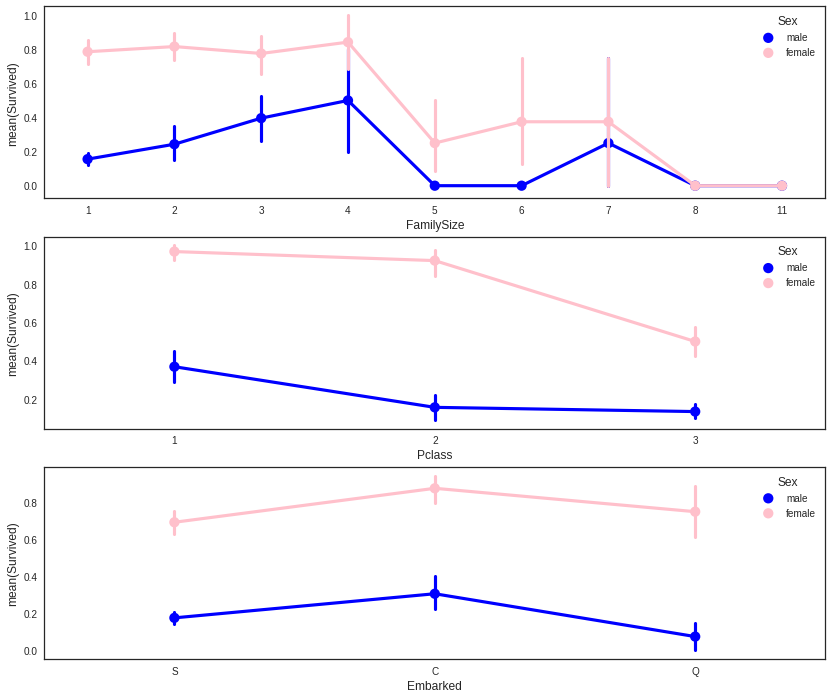

In [86]:
fig, (axis1, axis2, axis3) = plt.subplots(3, 1, figsize=(14, 12))

sns.pointplot(
    x = 'FamilySize',
    y = 'Survived',
    hue = 'Sex',
    palette={"male": "blue", "female": "pink"},
    data = working_df,
    ax = axis1
)

sns.pointplot(
    x = 'Pclass',
    y = 'Survived',
    hue = 'Sex',
    palette={"male": "blue", "female": "pink"},
    data = working_df,
    ax = axis2
)

sns.pointplot(
    x = 'Embarked',
    y = 'Survived',
    hue = 'Sex',
    palette={"male": "blue", "female": "pink"},
    data = working_df,
    ax = axis3
)

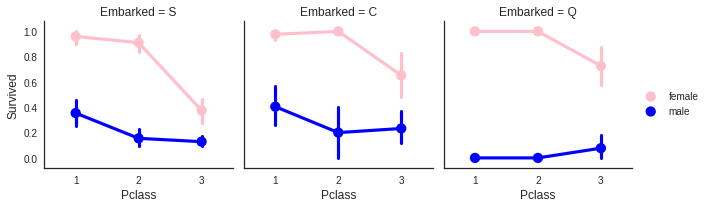

In [89]:
e = sns.FacetGrid(working_df, col='Embarked')
e.map(
    sns.pointplot,\
    'Pclass',
    'Survived',
    'Sex',
    ci=95.0,
    palette={"male": "blue", "female": "pink"}
)
e.add_legend()

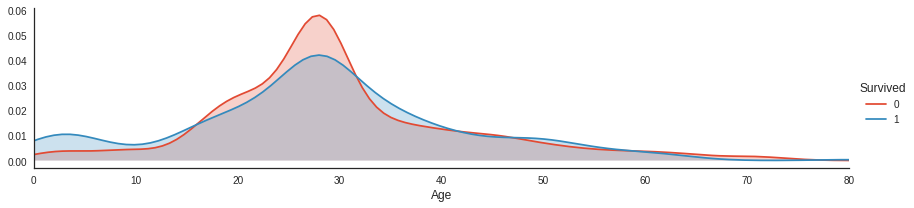

In [90]:
a = sns.FacetGrid(working_df, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, working_df['Age'].max()))
a.add_legend()

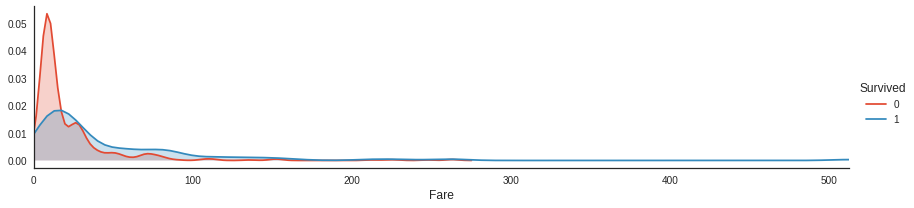

In [95]:
a = sns.FacetGrid(working_df, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Fare', shade=True)
a.set(xlim=(0, working_df['Fare'].max()))
a.add_legend()

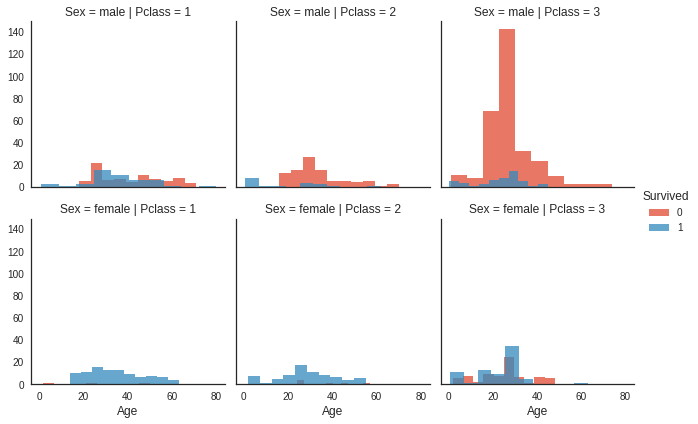

In [96]:
h = sns.FacetGrid(
    working_df,
    row='Sex',
    col='Pclass',
    hue='Survived')
h.map(plt.hist, 'Age', alpha=0.75)
h.add_legend()

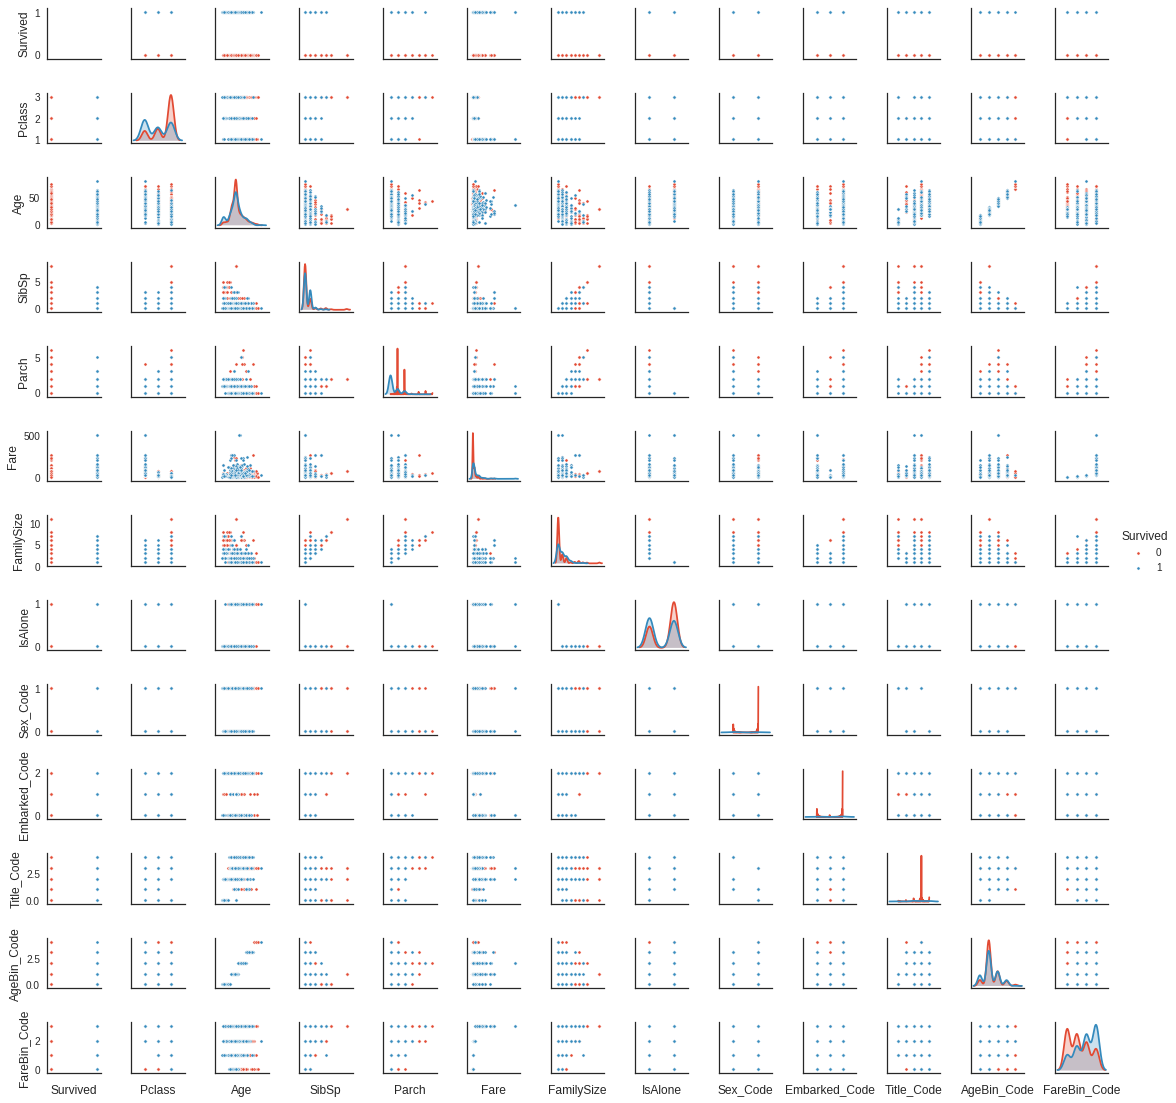

In [97]:
pp = sns.pairplot(
    working_df,
    hue='Survived',
    size=1.2,
    diag_kind='kde',
    diag_kws=(dict(shade=True)),
    plot_kws=(dict(s=10))
)
pp.set(xticklabels=[])

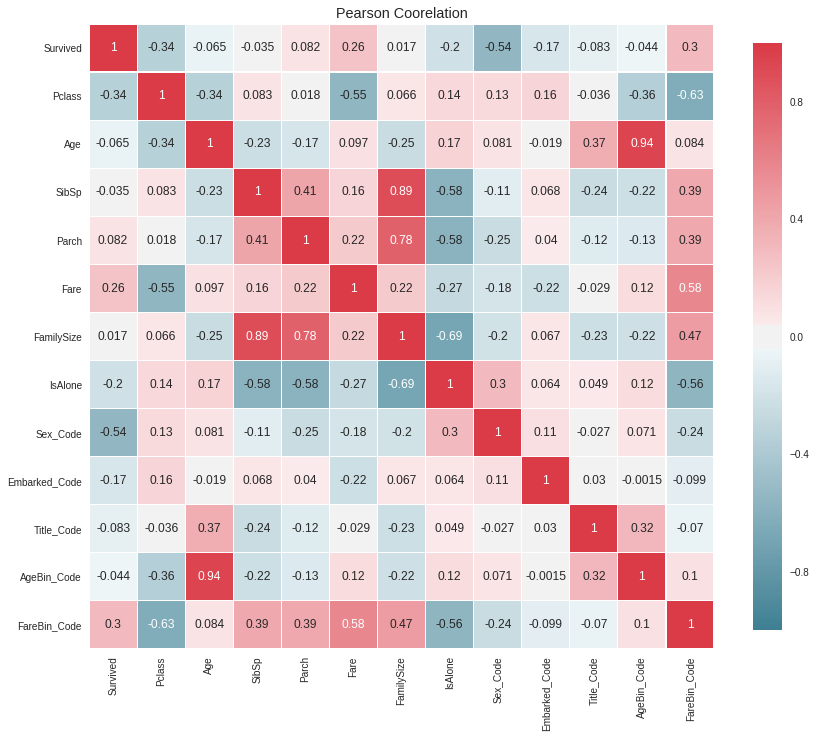

In [100]:
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink': 0.9},
        ax=ax,
        annot=True,
        linewidths=0.1,
        vmax=1.0,
        linecolor='white',
        annot_kws={'fontsize':12}
    )
    
    plt.title("Pearson Coorelation")
    
correlation_heatmap(working_df)

In [114]:
for index, row in working_df.iterrows():
    if random.random() > 0.5:
        working_df.set_value(index, 'Random Prediction', 1)
    else:
        working_df.set_value(index, 'Random Prediction', 0)
        
print('Coin Flip Model Accuracy: {:.2f}%'.format(
    metrics.accuracy_score(
        working_df['Survived'],
        working_df['Random Prediction']) * 100))

Coin Flip Model Accuracy: 51.29%


In [120]:
pivot_female = working_df[working_df.Sex == 'female'].groupby([
    'Sex',
    'Pclass',
    'Embarked',
    'FareBin'
])['Survived'].mean()
print('Survival Decision Treet, Female Node', pivot_female)

pivot_male = working_df[working_df.Sex == 'male'].groupby([
    'Sex',
    'Pclass',
    'Title'
])['Survived'].mean()
print('Survival Decision Treet, Male Node', pivot_male)

Survival Decision Treet, Female Node Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000
   